In [1]:
import tensorflow as tf
import numpy as np

def conv( x, filter_size=3, stride=2, num_filters=64, is_output=False, name="conv" ):
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
      Create a W filter variable with the proper size
      Create a B bias variable with the proper size
      Convolve x with W by calling the tf.nn.conv2d function
      Add the bias
      If is_output is False,
        Call the tf.nn.relu function
      Return the final op
    '''
    # The format of shape is [batch_size, height, width, channels]
    input_shape = x.get_shape().as_list()

    with tf.name_scope(name):
        W = tf.get_variable(name+"_W", shape=[filter_size,filter_size,input_shape[3],num_filters], initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable(name+"_b", shape=num_filters)

        if(not is_output):
            h = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(x,W, strides=[1,stride,stride,1],padding="SAME"),b))
        else:
            h = tf.nn.bias_add(tf.nn.conv2d(x,W, strides=[1,stride,stride,1],padding="SAME"),b)

    return h

def fc( x, out_size=50, name="fc", is_output=False):
    '''
    x is an input tensor
    Declare a name scope using the "name" parameter
    Within that scope:
      Create a W filter variable with the proper size
      Create a B bias variable with the proper size
      Multiply x by W and add b
      If is_output is False,
        Call the tf.nn.relu function
      Return the final op
    '''
    input_shape = x.get_shape().as_list()

    with tf.name_scope(name):
        W = tf.get_variable(name+"_W", shape=[input_shape[1],out_size], initializer=tf.contrib.layers.variance_scaling_initializer())
        b = tf.get_variable(name+"_b", shape=[out_size])

        if(not is_output):
            h = tf.nn.relu(tf.nn.bias_add(tf.matmul(x,W),b))
        else:
            h = tf.nn.bias_add(tf.matmul(x,W),b)


    return h


def unpickle( file ):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

if __name__=='__main__':

    # Define the computation graph for training the DNN--------------------------------------#
    input_data = tf.placeholder( tf.float32, [1,32,32,3] )
    h0 = conv( input_data, name="conv1", stride=1)
    h1 = conv( h0, name="conv2", stride=1 )
    #h2 = conv( h1, name="conv3", stride=2)
    h3 = conv( h1, name="conv4", stride=2)

    # Flatten to prepare for fully connected layer
    h3_flat = tf.reshape(h3,shape=[1,-1])

    h4 = fc(h3_flat, name="fc1", out_size=256)
    #h5 = fc(h4, name="fc2", out_size=64)
    h6 = fc(h4, name="fc3", out_size=10, is_output=True)

    with tf.name_scope("loss_function"):
        true_label = tf.placeholder(tf.int64, 1)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_label[0],logits=h6[0])


    with tf.name_scope("accuracy"):
        y = tf.nn.softmax(h6)
        prediction = tf.argmax(y,1)
        accuracy = tf.equal(prediction,true_label)


    training_step = tf.train.AdamOptimizer( 1e-4 ).minimize( loss )

    #----------------------------------END COMPUTATION GRAPH----------------------------------#

    # Load the data
    data = unpickle( 'cifar-10-batches-py/data_batch_1' )

    features = data['data']
    labels = data['labels']
    labels = np.atleast_2d( labels ).T

    train_features = features[0:8000]
    train_labels = labels[0:8000]
    val_features = features[8000:10000]
    val_labels = labels[8000:10000]

    # Run the DNN
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    # Declare things you want to visualize
    tf.summary.scalar('loss',loss)
    merged = tf.summary.merge_all()

    writer = tf.summary.FileWriter("./tf_logs", sess.graph)
    test_accuracies = []
    train_accuracies = []

    for epoch in xrange(0,20):

        for i in xrange(0,len(train_labels)):

            # Make a step
            sess.run(training_step, {input_data:train_features[i].reshape(-1,32,32,3),true_label:train_labels[i]})


            if i%5000==0:
                # Calculate accuracy
                test_acc = 0
                train_acc = 0
                for j in xrange(0,len(val_features)):
                    test_acc = test_acc + sess.run(accuracy,{input_data:val_features[j].reshape(-1,32,32,3),true_label:val_labels[j]})
                    train_acc = train_acc + sess.run(accuracy,{input_data:train_features[j].reshape(-1,32,32,3),true_label:train_labels[j]})
                test_acc_percent = test_acc/(float(len(val_labels)))*100.0
                train_acc_percent = train_acc/(float(len(val_labels)))*100.0
                test_accuracies.append(test_acc_percent)
                train_accuracies.append(train_acc_percent)
                print "Epoch: ", epoch
                print "Training Percent Accuracy: ", train_acc_percent
                print "Test Percent Accuracy: ", test_acc_percent
            

            # For Tensorboard visualization
            my_scalars = sess.run(merged, {input_data:features[i].reshape(-1,32,32,3),true_label:labels[i]})
            writer.add_summary(my_scalars,i)

    writer.close()
    
    


Epoch:  0
Training Percent Accuracy:  [ 10.35]
Test Percent Accuracy:  [ 9.9]
Epoch:  0
Training Percent Accuracy:  [ 25.05]
Test Percent Accuracy:  [ 21.9]
Epoch:  1
Training Percent Accuracy:  [ 25.4]
Test Percent Accuracy:  [ 23.1]
Epoch:  1
Training Percent Accuracy:  [ 28.4]
Test Percent Accuracy:  [ 25.45]
Epoch:  2
Training Percent Accuracy:  [ 33.8]
Test Percent Accuracy:  [ 29.4]
Epoch:  2
Training Percent Accuracy:  [ 35.25]
Test Percent Accuracy:  [ 29.85]
Epoch:  3
Training Percent Accuracy:  [ 37.05]
Test Percent Accuracy:  [ 31.5]
Epoch:  3
Training Percent Accuracy:  [ 44.5]
Test Percent Accuracy:  [ 35.05]
Epoch:  4
Training Percent Accuracy:  [ 43.95]
Test Percent Accuracy:  [ 33.05]
Epoch:  4
Training Percent Accuracy:  [ 47.65]
Test Percent Accuracy:  [ 34.95]
Epoch:  5
Training Percent Accuracy:  [ 53.45]
Test Percent Accuracy:  [ 34.5]
Epoch:  5
Training Percent Accuracy:  [ 53.9]
Test Percent Accuracy:  [ 36.55]
Epoch:  6
Training Percent Accuracy:  [ 59.35]
Test 

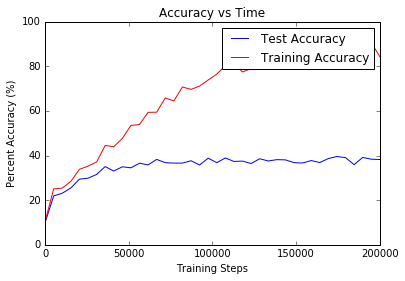

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

t = np.linspace(0,len(test_accuracies),len(test_accuracies))

fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.plot(t*5000,test_accuracies,'b',t*5000,train_accuracies,'r')
ax.set_xlabel('Training Steps')
ax.set_ylabel('Percent Accuracy (%)')
ax.set_title('Accuracy vs Time')
ax.legend(['Test Accuracy','Training Accuracy'])
plt.show()

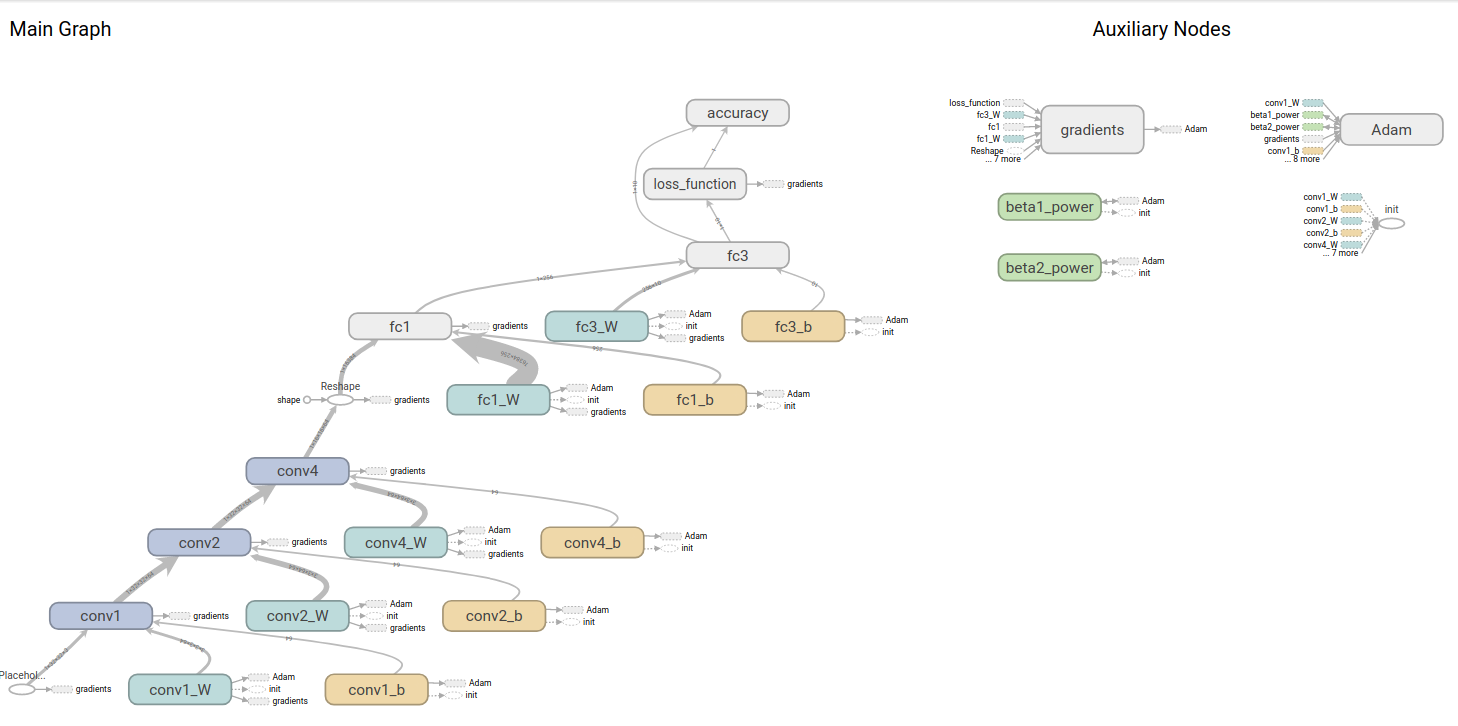

In [4]:
from IPython.display import display
from PIL import Image
img = Image.open('computation_graph.png')

display(img)